# The Obesity Epidemic and City Composition
_Capstone Project_

#### Import Required Libraries

In [91]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

#### Request obesity data and parse response

In [ ]:
# https://healthdata.gov/dataset/500-cities-local-data-better-health-2016-release
# https://data.cdc.gov/data.json
# https://data.cdc.gov/api/views/hn4x-zwk7/rows.json?accessType=DOWNLOAD

In [73]:
url_obesity_data = "https://www.stateofobesity.org/wp-json/state-of-obesity/v1/adult-obesity-data"
response = requests.get(url_obesity_data).json()

In [82]:
response_df = pd.DataFrame.from_dict(response)
response_df.head()
#obesity_data_df.to_csv("assets/national_obesity_data.csv")

,ab,fips,st,yr1990,yr1990cnf,yr1990rnk,yr1995,yr1995cnf,yr1995rnk,yr2000,...,yr2014rnk,yr2015,yr2015cnf,yr2015rnk,yr2016,yr2016cnf,yr2016rnk,yr2017,yr2017cnf,yr2017rnk
0,AL,01,Alabama,11.2,1.0,21.0,15.7,1.1,17,22.6,...,5,35.6,1.5,2,35.7,1.6,3,36.3,1.6,5
1,AK,02,Alaska,NaN,NaN,NaN,15.7,1.5,17,20.9,...,24,29.8,2.4,26,31.4,2.9,20,34.2,2.9,9
2,AZ,04,Arizona,10.6,1.2,29.0,12.6,1.3,44,14.9,...,29,28.4,1.6,34,29.0,1.5,29,29.5,1.0,30
3,AR,05,Arkansas,NaN,NaN,NaN,17.0,1.2,5,21.9,...,1,34.5,2.3,6,35.7,2.4,3,35.0,2.4,7
4,CA,06,California,9.9,0.9,37.0,13.9,0.9,32,18.7,...,47,24.2,1.0,47,25.0,1.1,47,25.1,1.3,48


In [83]:
response_df.columns

Index(['ab', 'fips', 'st', 'yr1990', 'yr1990cnf', 'yr1990rnk', 'yr1995',
       'yr1995cnf', 'yr1995rnk', 'yr2000', 'yr2000cnf', 'yr2000rnk', 'yr2003',
       'yr2003cnf', 'yr2003rnk', 'yr2004', 'yr2004cnf', 'yr2004rnk', 'yr2005',
       'yr2005cnf', 'yr2005rnk', 'yr2006', 'yr2006cnf', 'yr2006rnk', 'yr2007',
       'yr2007cnf', 'yr2007rnk', 'yr2008', 'yr2008cnf', 'yr2008rnk', 'yr2009',
       'yr2009cnf', 'yr2009rnk', 'yr2010', 'yr2010cnf', 'yr2010rnk', 'yr2011',
       'yr2011cnf', 'yr2011rnk', 'yr2012', 'yr2012cnf', 'yr2012rnk', 'yr2013',
       'yr2013cnf', 'yr2013rnk', 'yr2014', 'yr2014cnf', 'yr2014rnk', 'yr2015',
       'yr2015cnf', 'yr2015rnk', 'yr2016', 'yr2016cnf', 'yr2016rnk', 'yr2017',
       'yr2017cnf', 'yr2017rnk'],
      dtype='object')

In [112]:
cols = ["st"]
for i in range(0, 18):
    if i not in [1, 2]:
        if i < 10:
            cols.append("yr200" + str(i))
        else:
            cols.append("yr20" + str(i))

obesity_rates_df = response_df[cols]
obesity_rates_df = obesity_rates_df.set_index("st")
obesity_rates_df.index.name = "State"
obesity_rates_df.columns = [col[-4:] for col in obesity_rates_df.columns]
obesity_rates_df.head()

,2000,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
State,,,,,,,,,,,,,,,,
Alabama,22.6,28.4,27.7,28.7,29.4,30.1,31.2,31.6,32.3,32.0,33.0,32.4,33.5,35.6,35.7,36.3
Alaska,20.9,23.5,23.5,24.9,25.8,27.3,27.2,26.9,25.9,27.4,25.7,28.4,29.7,29.8,31.4,34.2
Arizona,14.9,20.1,20.3,20.8,21.7,23.3,24.8,25.8,25.4,24.7,26.0,26.8,28.9,28.4,29.0,29.5
Arkansas,21.9,25.2,25.0,26.4,27.0,28.1,28.6,30.1,30.6,30.9,34.5,34.6,35.9,34.5,35.7,35.0
California,18.7,23.2,21.5,22.7,22.7,23.1,23.6,24.4,24.8,23.8,25.0,24.1,24.7,24.2,25.0,25.1


In [118]:
obesity_rates_df.describe()

,2000,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,51.000000,51.000000,50.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,19.103922,22.415686,22.528000,23.337255,24.225490,25.270588,25.984314,26.723529,27.178431,27.584314,27.945098,28.650980,29.225490,29.282353,29.792157,30.600000
std,2.390645,2.837349,2.604003,2.780285,2.804485,2.882450,2.904092,3.100619,3.214736,3.049483,3.375874,3.435076,3.416773,3.870850,3.738975,3.852012
min,14.500000,16.000000,16.400000,16.900000,17.600000,18.400000,18.900000,19.100000,19.800000,20.700000,20.500000,21.300000,21.300000,20.200000,22.300000,22.600000
25%,17.050000,20.200000,20.750000,21.600000,22.400000,23.300000,24.200000,25.050000,25.150000,25.200000,25.650000,26.350000,27.150000,26.200000,27.250000,27.900000
50%,19.400000,22.900000,22.600000,23.200000,24.400000,25.300000,26.000000,26.600000,27.100000,27.800000,27.600000,29.400000,29.600000,29.800000,29.900000,31.300000
75%,20.900000,24.450000,24.325000,25.300000,26.200000,27.350000,28.000000,29.000000,29.500000,29.600000,30.000000,31.050000,31.250000,31.550000,32.000000,33.100000
max,23.900000,28.400000,28.100000,29.500000,30.600000,31.700000,32.500000,33.800000,34.400000,34.900000,34.700000,35.100000,35.900000,36.200000,37.700000,38.100000


#### Examine obesity rate data on a national level

#### Examine obesity rate trends by state

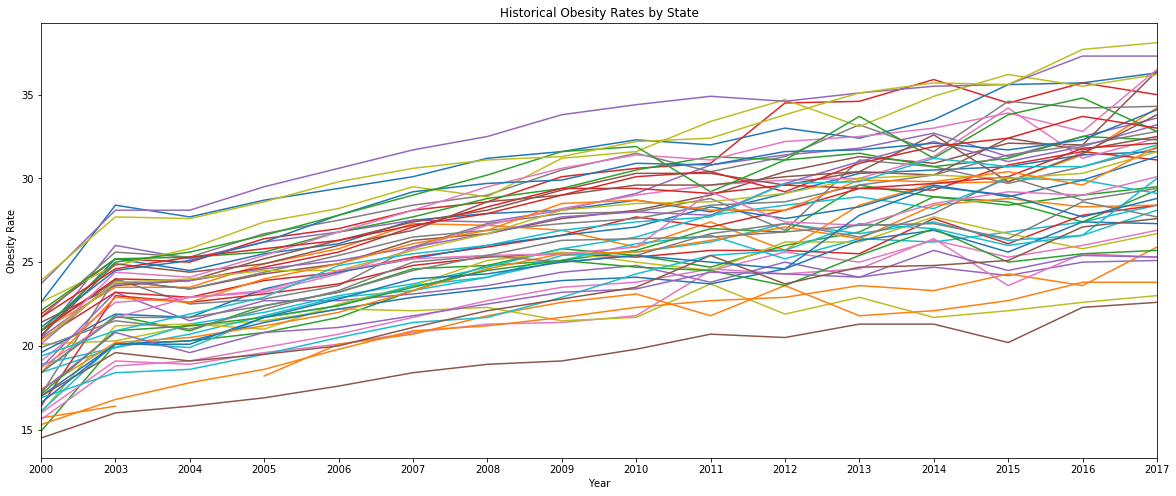

In [117]:
fig = plt.figure(figsize=(20,8))

plt.plot(obesity_rates_df.T)
plt.title("Historical Obesity Rates by State")
plt.xlim("2000", "2017")
plt.xlabel("Year")
plt.ylabel("Obesity Rate")
plt.show()

In [ ]:
# Create some visuals along the lines of: https://www.stateofobesity.org/adult-obesity/

#### Determine the most and least obese states

#### Leverage City-Data.com for zipcode and neighborhood data

#### Utilize the Foursquare API to determine the most common venue categories in target areas